In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
sns.set_style("whitegrid")

In [2]:
a = 3
b = 2
alpha = a/b

S = 100
num_r = S + 1 + 2*a
num_s = S + 1 + 2*b
num_c = S + 1 + 2*b

r_init = 3*S//4
s_init = 3*S//4
c_init = S//4

In [3]:
#fit_parameters = np.load(r'C:\Users\Rohit Vasav\Downloads\params_f_range.npz')
#k_off, k_u, k_b, j_off, J_on_hat, g_off = fit_parameters['params'][0,0]

## Parameters obtained from experimental data
k_off, k_u, k_b, j_off, J_on_hat, g_off = [3.9018766517549692, 1.9799379861044861, 6.615504603306438, 
                                           3.481669158554892, 3.016688368288114, 5.910017828840013]

G_on = J_on_hat/(1+j_off/g_off)
J_on = J_on_hat - G_on

K_on = k_off/(1+(k_b/k_u)*J_on_hat/(j_off+g_off)) - G_on + g_off*J_on_hat/(j_off+g_off)

## Theoretical steady state values
r_star = J_on_hat / (j_off + g_off)
s_star = (K_on + G_on -g_off*r_star) / k_off
c_star = k_b/k_u * r_star * s_star

## Scaling the parameters with S
J_on *= S
G_on *= S
k_b /= S
K_on *= S

r_star *= S
s_star *= S
c_star *= S

In [4]:
T_end = 3
dt = 1/2000

time_arr = np.arange(0,T_end,dt)
time_steps = len(time_arr)

In [5]:
def solve(r_init, s_init, c_init, time_steps, num_r, num_s, num_c):
    
    p = np.zeros((num_r,num_s,num_c,time_steps),dtype=np.float32)
    
    c = np.zeros((S+1, S+1, S+1))
    c[:, :, :] = np.arange(0,S+1)
    
    r = np.zeros((S+1, S+1, S+1))
    r[:, :, :] = np.arange(0, S + 1).reshape((S+1, 1, 1))

    s = np.zeros((S+1, S+1, S+1))
    s[:, :, :] = np.arange(0, S + 1).reshape((1, S+1, 1))
    
    const = np.ones((S+1,S+1,S+1))

    p[r_init+a,s_init+b,c_init+b,0] = 1
    
    for t in tqdm(range(1,time_steps)):

        rates = np.stack((J_on*const, G_on*const, (k_u/b)*c, g_off*r, j_off*r, (k_b/b)*r*s, K_on*const, k_off*s),axis=0)
        
        prob = np.stack((p[a-1:num_r-a-1, b:num_s-b, b:num_c-b, t-1], p[a-1:num_r-a-1, b-1:num_s-b-1, b:num_c-b, t-1],
                        p[0:num_r-2*a, 0:num_s-2*b, 2*b:num_c, t-1], p[a+1:num_r-a+1, b+1:num_s-b+1, b:num_c-b, t-1],
                        p[a+1:num_r-a+1, b:num_s-b, b:num_c-b, t-1], p[2*a:num_r, 2*b:num_s, 0:num_c-2*b, t-1],
                        p[a:num_r-a, b-1:num_s-b-1, b:num_c-b, t-1], p[a:num_r-a, b+1:num_s-b+1, b:num_c-b,t-1]),axis=0)

        p[a:num_r-a, b:num_s-b, b:num_c-b, t] = p[a:num_r-a, b:num_s-b, b:num_c-b, t-1] + dt*(-np.sum(rates,axis=0)*p[a:num_r-a, b:num_s-b, b:num_c-b, t-1] + np.sum(rates*prob,axis=0))
                    
        p[:,:,:,t] = p[:,:,:,t]/np.sum(p[:,:,:,t])
                    
    return p,r,s,c

In [6]:
p,r,s,c = solve(r_init, s_init, c_init, time_steps, num_r, num_s, num_c)

100%|██████████████████████████████████████████████████| 5999/5999 [48:24<00:00,  2.07it/s]


In [7]:
np.max(p), np.min(p)

(1.0, 0.0)

In [8]:
p_r = np.sum(p[a:num_r-a, b:num_s-b, b:num_c-b], axis=(1,2))
p_s = np.sum(p[a:num_r-a, b:num_s-b, b:num_c-b], axis=(0,2))
p_c = np.sum(p[a:num_r-a, b:num_s-b, b:num_c-b], axis=(0,1))

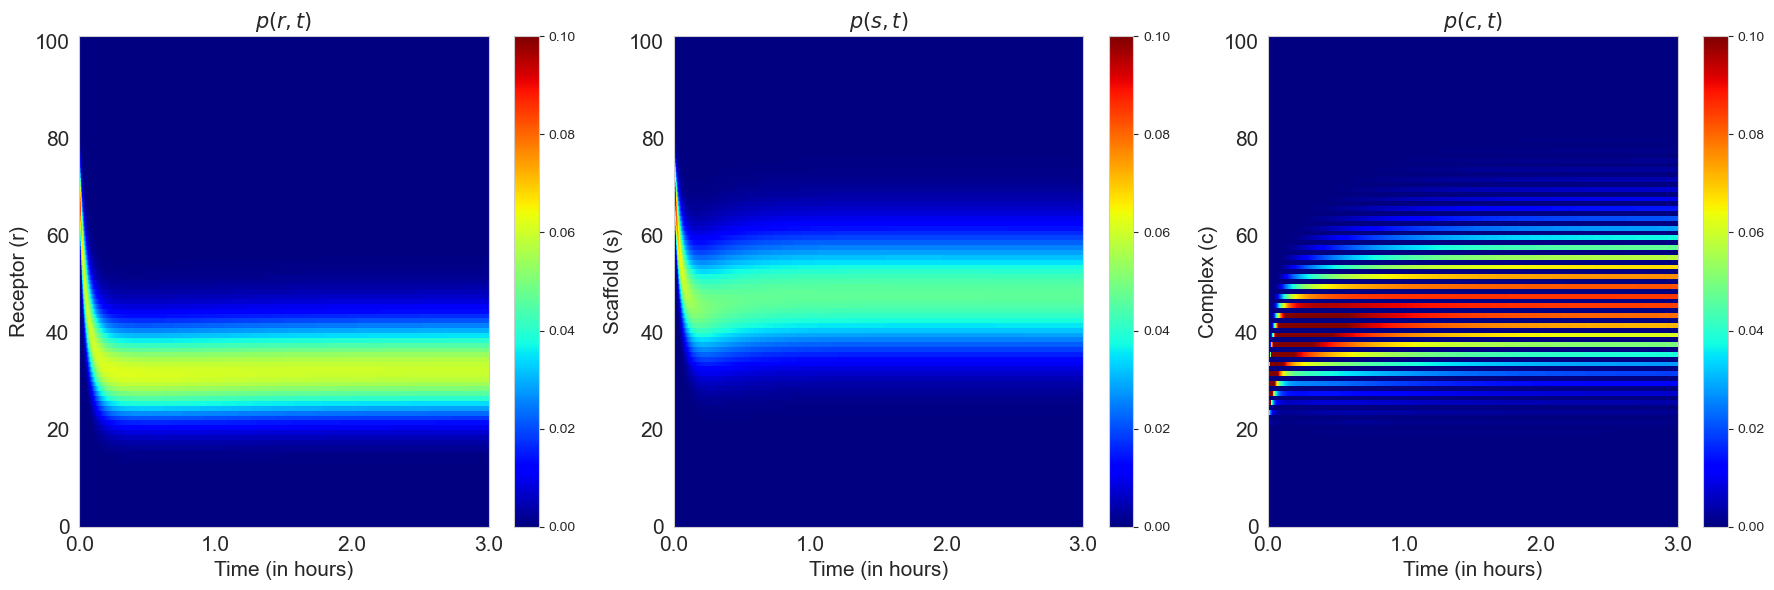

In [60]:
fig, axs = plt.subplots(1, 3, figsize=(18,6),sharex=True)

ax = axs[0]
co = ax.pcolor(p_r, cmap='jet', vmin=0, vmax=0.1)
fig.colorbar(co, ax=ax)
ax.set_xlabel("Time (in hours)",fontsize=15)
ax.set_ylabel("Receptor (r)",fontsize=15)
ax.set_title("$p(r,t)$",fontsize=15)
ax.set_xticks(np.arange(0, time_steps+1, time_steps//T_end), np.arange(0,T_end+dt,(time_steps//T_end)*dt).round(4))
ax.tick_params(axis='both', labelsize=15)

ax = axs[1]
co = ax.pcolormesh(p_s, cmap='jet', vmin=0, vmax=0.1)
fig.colorbar(co, ax=ax)
ax.set_xlabel("Time (in hours)",fontsize=15)
ax.set_ylabel("Scaffold (s)",fontsize=15)
ax.set_title("$p(s,t)$",fontsize=15)
ax.set_xticks(np.arange(0, time_steps+1, time_steps//T_end), np.arange(0,T_end+dt,(time_steps//T_end)*dt).round(4))
ax.tick_params(axis='both', labelsize=15)

ax = axs[2]
co = ax.pcolormesh(p_c, cmap='jet', vmin=0, vmax=0.1)
fig.colorbar(co, ax=ax)
ax.set_xlabel("Time (in hours)",fontsize=15)
ax.set_ylabel("Complex (c)",fontsize=15)
ax.set_title("$p(c,t)$",fontsize=15)
ax.set_xticks(np.arange(0, time_steps+1, time_steps//T_end), np.arange(0,T_end+dt,(time_steps//T_end)*dt).round(4))
ax.tick_params(axis='both', labelsize=15)

#fig.suptitle("Time evolution of probabilities \n S = "+str(S))
fig.tight_layout()
plt.savefig("/users/nsr/rvasav/Internship/Graphs/Probablity_Evolution_Master_Equation.png",dpi=200)
plt.show()

In [10]:
mean_p_r = p_r[:,-1]
mean_p_s = p_s[:,-1]
mean_p_c = p_c[:,-1]

In [11]:
r_stat = np.load('/users/nsr/rvasav/Internship/Data/r_stat.npy')
s_stat = np.load('/users/nsr/rvasav/Internship/Data/s_stat.npy')
c_stat = np.load('/users/nsr/rvasav/Internship/Data/c_stat.npy')

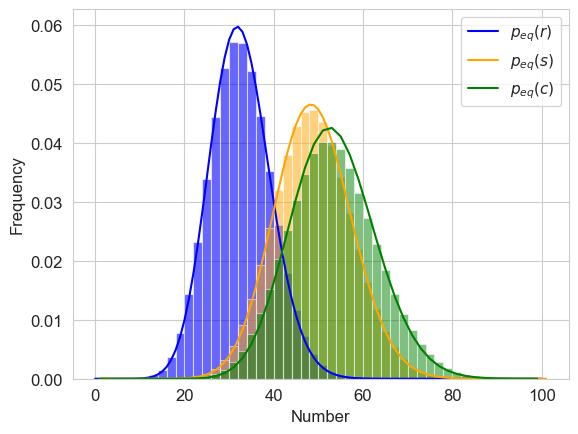

In [63]:
plt.hist(r_stat,bins=range(0,S+1,2),density=True,facecolor = 'blue',edgecolor = 'white',linewidth=0.8,alpha=0.6)
plt.hist(s_stat,bins=range(0,S+1,2),density=True,facecolor = 'orange',edgecolor = 'white',linewidth=0.8,alpha=0.5)
plt.hist(c_stat,bins=range(0,S+1,2),density=True,facecolor = 'green',edgecolor = 'white',linewidth=0.8,alpha=0.5)

plt.plot(range(0,S+1),mean_p_r,color='blue',label='$p_{eq}(r)$')
plt.plot(range(1,S+1+1),mean_p_s,color='orange',label='$p_{eq}(s)$')
plt.plot(range(1,S+1,2),np.roll(mean_p_c[mean_p_c!=0],3)/2,color='green',label='$p_{eq}(c)$')

plt.ylabel('Frequency',fontsize=12)
plt.xlabel("Number",fontsize=12)

plt.legend(fontsize=11)
plt.tick_params(axis='both', labelsize=12)

#plt.title('Equilibrium Probablity Distributions')
plt.savefig("/users/nsr/rvasav/Internship/Graphs/Master_Equation_Equilibrium_Probablity_Distributions.png",dpi=150)
plt.show()

In [13]:
p_eq = p[a:num_r-a, b:num_s-b, b:num_c-b, -1]

mu_r = np.sum(r*p_eq)
mu_s = np.sum(s*p_eq)
mu_c = np.sum(c*p_eq)

sigma_r = np.sqrt(np.sum((r**2)*p_eq) - mu_r**2)
sigma_s = np.sqrt(np.sum((s**2)*p_eq) - mu_s**2)
sigma_c = np.sqrt(np.sum((c**2)*p_eq) - mu_c**2)

cov_rs = (np.sum(r*s*p_eq) - mu_r*mu_s)/(sigma_r*sigma_s)
cov_sc = (np.sum(s*c*p_eq) - mu_s*mu_c)/(sigma_s*sigma_c)
cov_rc = (np.sum(r*c*p_eq) - mu_r*mu_c)/(sigma_r*sigma_c)

In [14]:
print(mu_r, r_star , np.abs(mu_r-r_star)/r_star * 100, "%")
print(mu_s, s_star , np.abs(mu_s-s_star)/s_star * 100, "%")
print(mu_c, c_star , np.abs(mu_c-c_star)/c_star * 100, "%")

32.513810144292336 32.120835930083445 1.2234246177909802 %
47.826404908460276 48.23360340267108 0.8442215913486018 %
47.32462729728933 51.766396597328914 8.580410443845288 %


In [15]:
cov_rs, cov_sc, cov_rc

(0.2685495283679433, 0.13715234662310596, -0.14350015966321877)